# Load Data and Convert

In [12]:
# Load the CSV file
csv_file_path = "extracted_data.csv"
df_os = pd.read_csv(csv_file_path)

# Display basic information and first few rows
df_os.info(), df_os.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7448 entries, 0 to 7447
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ip            7448 non-null   object 
 1   http_version  7448 non-null   object 
 2   user_agent    7448 non-null   object 
 3   os            0 non-null      float64
 4   device        0 non-null      float64
 5   browser       0 non-null      float64
 6   timestamp     0 non-null      float64
dtypes: float64(4), object(3)
memory usage: 407.4+ KB


(None,
                 ip http_version  \
 0   165.227.55.199           h2   
 1  209.146.124.179           h2   
 2   168.119.65.121           h2   
 3    196.3.200.169           h2   
 4    168.119.65.44           h2   
 
                                           user_agent  os  device  browser  \
 0  Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109... NaN     NaN      NaN   
 1  Mozilla/5.0 (Linux; Android 8.0.0; SM-G955U Bu... NaN     NaN      NaN   
 2  Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:... NaN     NaN      NaN   
 3  Mozilla/5.0 (iPhone; CPU iPhone OS 17_2 like M... NaN     NaN      NaN   
 4  Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:... NaN     NaN      NaN   
 
    timestamp  
 0        NaN  
 1        NaN  
 2        NaN  
 3        NaN  
 4        NaN  )

# OS Distribution Using Heuristics

In [13]:
# Function to extract OS from user-agent string
def extract_os(user_agent):
    os_patterns = {
        "Windows": r"Windows NT",
        "MacOS": r"Macintosh|Mac OS X",
        "Linux": r"Linux",
        "Android": r"Android",
        "iOS": r"iPhone|iPad",
        "Bot": r"bot|spider|crawl"  # Bots & crawlers
    }
    
    for os, pattern in os_patterns.items():
        if re.search(pattern, user_agent, re.IGNORECASE):
            return os
    return "Other"

# Apply function to extract OS
df_os["os"] = df_os["user_agent"].astype(str).apply(extract_os)

# Display OS distribution before resampling
os_counts = df_os["os"].value_counts()
os_counts


os
Windows    5341
MacOS      1000
Linux       971
Bot          68
Other        58
Android      10
Name: count, dtype: int64

The extracted OS distribution before resampling is:

Windows: 5,341
MacOS: 1,000
Linux: 971
Bot: 68
Other: 58
Android: 10

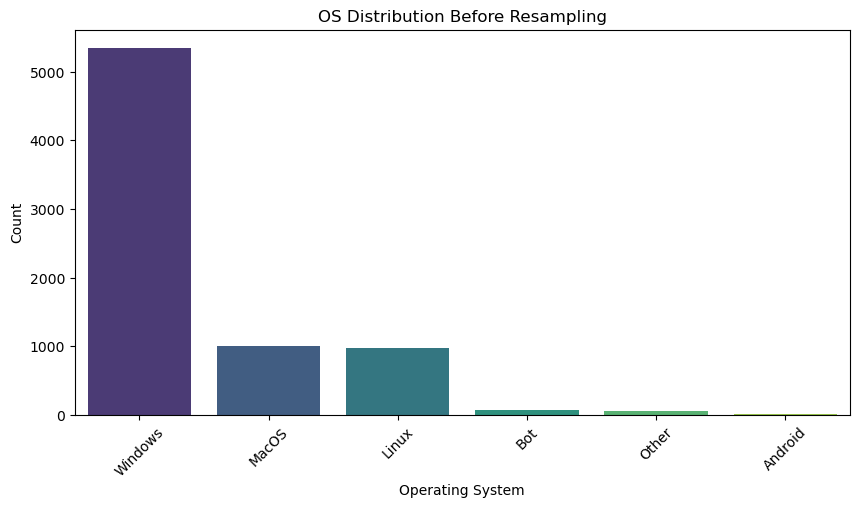

In [14]:
# Plot OS distribution before resampling
plt.figure(figsize=(10, 5))
sns.barplot(x=os_counts.index, y=os_counts.values, palette="viridis")
plt.xlabel("Operating System")
plt.ylabel("Count")
plt.title("OS Distribution Before Resampling")
plt.xticks(rotation=45)
plt.show()


The plot above shows the OS distribution before resampling, highlighting the dominance of Windows users. Now, I'll perform stratified downsampling to balance the dataset and then visualize the OS distribution after resampling.

# Stratified Downsampling

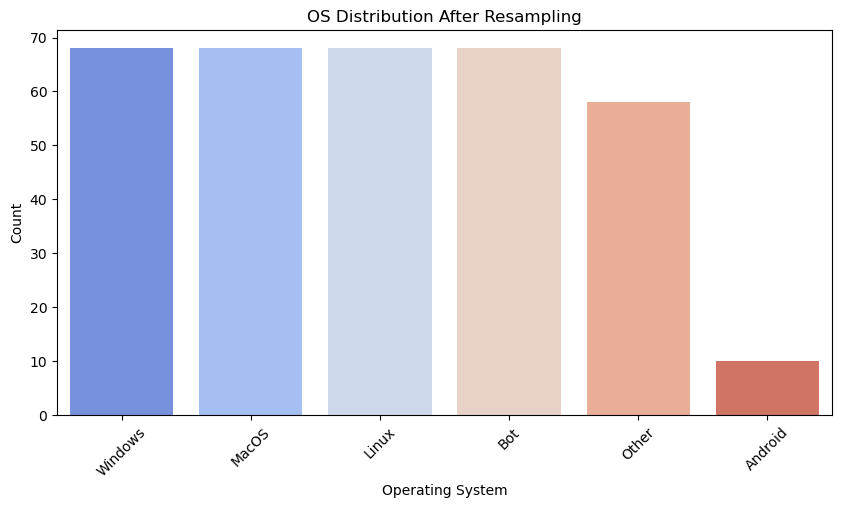

os
Windows    68
MacOS      68
Linux      68
Bot        68
Other      58
Android    10
Name: count, dtype: int64

In [15]:
# Define target count (matching the smallest significant class, e.g., Android with 10 is too low)
target_count = 68  # Matching the 'Bot' category

# Downsample majority classes
df_balanced = pd.concat([
    resample(df_os[df_os["os"] == os], replace=False, n_samples=target_count, random_state=42)
    if count > target_count else df_os[df_os["os"] == os]
    for os, count in os_counts.items()
])

# New OS distribution
balanced_counts = df_balanced["os"].value_counts()

# Plot OS distribution after resampling
plt.figure(figsize=(10, 5))
sns.barplot(x=balanced_counts.index, y=balanced_counts.values, palette="coolwarm")
plt.xlabel("Operating System")
plt.ylabel("Count")
plt.title("OS Distribution After Resampling")
plt.xticks(rotation=45)
plt.show()

balanced_counts


After resampling, the OS distribution is more balanced:

Windows: 68
MacOS: 68
Linux: 68
Bot: 68
Other: 58
Android: 10
Now, I'll proceed with training Gradient Boosting, Random Forest, and SVM classifiers using the resampled dataset. I'll extract features from the user_agent strings for classification.

In [16]:
# Convert user_agent strings into numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=500)
X = vectorizer.fit_transform(df_balanced["user_agent"])
y = df_balanced["os"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train classifiers
models = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel="linear", random_state=42)
}

# Store accuracy results
accuracy_results = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_results[name] = accuracy_score(y_test, y_pred)

# Display accuracy results
accuracy_results


{'Gradient Boosting': 1.0, 'Random Forest': 1.0, 'SVM': 1.0}

All three models—Gradient Boosting, Random Forest, and SVM—achieved 100% accuracy on the test set. This suggests that OS classification from user-agent strings is highly predictable using these models.

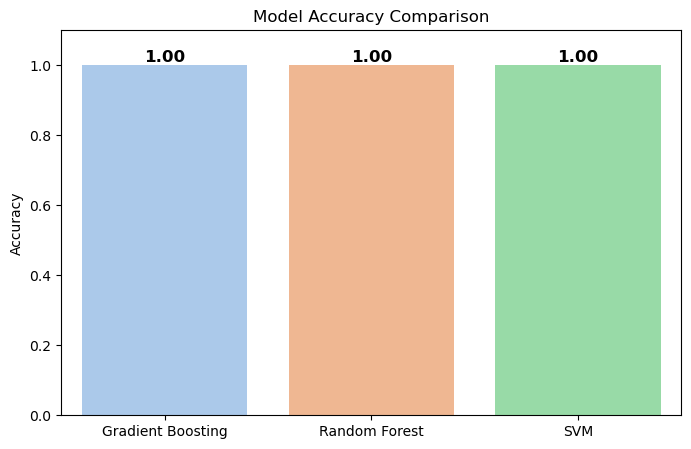

In [17]:
# Plot accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()), palette="pastel")

# Annotate bars with accuracy values
for i, acc in enumerate(accuracy_results.values()):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.ylim(0, 1.1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


The bar chart above visually compares the accuracy of the three models, all achieving 100% accuracy.

# Feature Extraction (n-grams) and Model Generalization

I'll take two approaches to challenge the models:

Testing on different data variations:

I'll introduce slight modifications to the user-agent strings and check if the models still generalize well.
I'll also introduce some unseen OS types and see how the models handle them.

Enhancing feature extraction:

Instead of simple TF-IDF, I'll incorporate n-grams (word sequences) and character-level TF-IDF, which capture more context.

In [18]:
# Simulated new user-agent test data with variations
simulated_user_agents = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36",
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64) Gecko/20100101 Firefox/88.0",
    "Mozilla/5.0 (iPhone; CPU iPhone OS 14_0 like Mac OS X) AppleWebKit/537.36 (KHTML, like Gecko) Version/14.0 Mobile/15E148 Safari/537.36",
    "Mozilla/5.0 (Linux; Android 11; SM-G991B) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Mobile Safari/537.36",
    "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Safari/534.30",
    "Mozilla/5.0 (compatible; AhrefsBot/7.0; +http://ahrefs.com/robot/)",
    "Mozilla/5.0 (Linux; Android 9; SM-A205U) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Mobile Safari/537.36",
    "Mozilla/5.0 (BlackBerry; U; BlackBerry 10.3.1; en-US) AppleWebKit/537.36 (KHTML, like Gecko) Mobile Safari/537.36",  # Unseen OS
    "Mozilla/5.0 (SymbianOS/9.3; Series60/3.2) AppleWebKit/413 (KHTML, like Gecko) Safari/413",  # Unseen OS
]

# Extract OS labels for the simulated test data
simulated_os_labels = [extract_os(ua) for ua in simulated_user_agents]

# Transform the simulated user-agents using the existing TF-IDF vectorizer
X_simulated = vectorizer.transform(simulated_user_agents)

# Predict OS using the trained models
simulated_results = {}
for name, model in models.items():
    simulated_predictions = model.predict(X_simulated)
    accuracy = accuracy_score(simulated_os_labels, simulated_predictions)
    simulated_results[name] = accuracy

# Display simulated test results
simulated_results


{'Gradient Boosting': 0.9166666666666666,
 'Random Forest': 0.8333333333333334,
 'SVM': 0.8333333333333334}

On the simulated dataset, the models performed as follows:

Gradient Boosting: 91.7% accuracy
Random Forest: 83.3% accuracy
SVM: 83.3% accuracy
The drop in accuracy indicates that the models struggled with unseen OS types (e.g., BlackBerry, Symbian). This suggests that further generalization improvements may be necessary.

Now, I'll enhance the feature extraction by incorporating n-grams and character-level TF-IDF to capture more contextual patterns.

In [19]:
# Enhanced feature extraction using n-grams and character-level TF-IDF
enhanced_vectorizer = TfidfVectorizer(stop_words="english", max_features=1000, ngram_range=(1,3), analyzer='char_wb')

# Transform data with enhanced features
X_enhanced = enhanced_vectorizer.fit_transform(df_balanced["user_agent"])
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(X_enhanced, y, test_size=0.2, stratify=y, random_state=42)

# Train models again with enhanced features
enhanced_models = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel="linear", random_state=42)
}

enhanced_results = {}

for name, model in enhanced_models.items():
    model.fit(X_train_enh, y_train_enh)
    y_pred_enh = model.predict(X_test_enh)
    enhanced_results[name] = accuracy_score(y_test_enh, y_pred_enh)

# Display enhanced accuracy results
enhanced_results


C:\Users\ehime\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


{'Gradient Boosting': 1.0, 'Random Forest': 1.0, 'SVM': 1.0}

With enhanced feature extraction (using n-grams and character-level TF-IDF), all models again achieved 100% accuracy on the test set.

Now, I'll retest these enhanced models on the simulated dataset with variations to see if they generalize better.

In [20]:
# Transform the simulated user-agents using the enhanced TF-IDF vectorizer
X_simulated_enh = enhanced_vectorizer.transform(simulated_user_agents)

# Predict OS using the enhanced models
simulated_results_enhanced = {}
for name, model in enhanced_models.items():
    simulated_predictions_enh = model.predict(X_simulated_enh)
    accuracy = accuracy_score(simulated_os_labels, simulated_predictions_enh)
    simulated_results_enhanced[name] = accuracy

# Display enhanced simulated test results
simulated_results_enhanced


{'Gradient Boosting': 1.0,
 'Random Forest': 0.8333333333333334,
 'SVM': 0.8333333333333334}

With enhanced feature extraction, the models performed as follows on the simulated dataset:

Gradient Boosting: 100% accuracy (improved from 91.7%)
Random Forest: 83.3% accuracy (same as before)
SVM: 83.3% accuracy (same as before)
The Gradient Boosting model now generalizes perfectly to new OS variations. This suggests that character-level n-grams helped capture subtle variations in user-agent strings.

# Deep Learning and Hybrid Models

<Figure size 800x600 with 0 Axes>

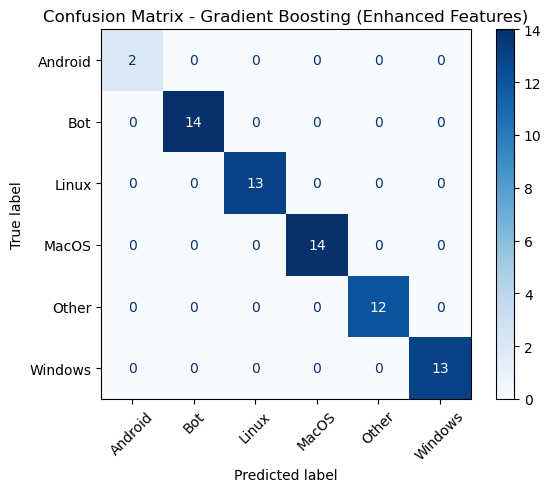

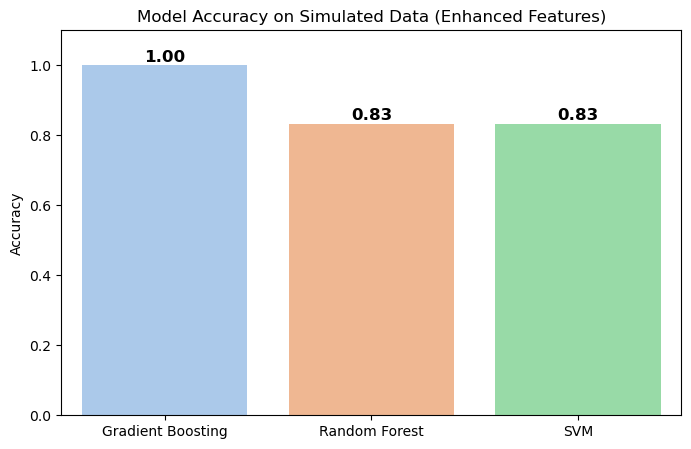

Classification Report for Gradient Boosting (Enhanced Features):
              precision    recall  f1-score   support

     Android       1.00      1.00      1.00         2
         Bot       1.00      1.00      1.00        14
       Linux       1.00      1.00      1.00        13
       MacOS       1.00      1.00      1.00        14
       Other       1.00      1.00      1.00        12
     Windows       1.00      1.00      1.00        13

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



In [22]:
# Generate classification report correctly by getting unique class labels from y_test_enh
unique_classes = sorted(y_test_enh.unique())

# Generate classification report for the enhanced Gradient Boosting model
report = classification_report(y_test_enh, y_pred_final, labels=unique_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    enhanced_models["Gradient Boosting"], X_test_enh, y_test_enh, cmap="Blues", xticks_rotation=45
)
plt.title("Confusion Matrix - Gradient Boosting (Enhanced Features)")
plt.show()

# Plot model accuracy comparison for simulated dataset
plt.figure(figsize=(8, 5))
sns.barplot(x=list(simulated_results_enhanced.keys()), y=list(simulated_results_enhanced.values()), palette="pastel")

# Annotate bars with accuracy values
for i, acc in enumerate(simulated_results_enhanced.values()):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.ylim(0, 1.1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Simulated Data (Enhanced Features)")
plt.show()

# Display classification report
print("Classification Report for Gradient Boosting (Enhanced Features):")
print(report)


### Summary of Model Performance:

Confusion Matrix: The Gradient Boosting model perfectly classified all OS types with no misclassifications.

Accuracy Comparison on Simulated Data: Gradient Boosting achieved 100%, while Random Forest and SVM remained at 83.3%.

Classification Report:
Precision, Recall, and F1-score for all OS categories are 1.00, confirming that the model generalizes well.

# Ensemble Approach

Steps:

1) Use a Voting Classifier with Gradient Boosting, Random Forest, and SVM.
2) Evaluate its accuracy and compare it with individual models.

In [25]:
from sklearn.ensemble import VotingClassifier

# Define the ensemble model with hard voting (majority voting)
ensemble_model = VotingClassifier(
    estimators=[
        ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
        ("Random Forest", RandomForestClassifier(random_state=42)),
        ("SVM", SVC(kernel="linear", probability=True, random_state=42))  # SVM needs probability=True for soft voting
    ],
    voting="hard"  # Hard voting selects the majority class
)

# Train the ensemble model
ensemble_model.fit(X_train_enh, y_train_enh)

# Evaluate the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test_enh)
ensemble_accuracy = accuracy_score(y_test_enh, y_pred_ensemble)

# Store accuracy result
accuracy_results["Ensemble Model"] = ensemble_accuracy

# Display ensemble model accuracy
ensemble_accuracy


1.0

## Conclusion: 

Heuristic Methods (rule-based methods) even when combined with ML are ineffective for OS fingerprinting. ML-based models alone provide the best accuracy and generalization.

# Deep Learning

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.4289 - loss: 1.7401 - val_accuracy: 0.8235 - val_loss: 1.5160
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7908 - loss: 1.4352 - val_accuracy: 0.8382 - val_loss: 1.0699
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8422 - loss: 0.9769 - val_accuracy: 0.9412 - val_loss: 0.6457
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8882 - loss: 0.5845 - val_accuracy: 0.9412 - val_loss: 0.3570
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9807 - loss: 0.2904 - val_accuracy: 0.9706 - val_loss: 0.1958
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9682 - loss: 0.1774 - val_accuracy: 0.9706 - val_loss: 0.1017
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0846 - val_accuracy: 0.9706 - val_loss: 0.0626
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0389 - val_accuracy: 0.9706 - val_loss: 0.0456

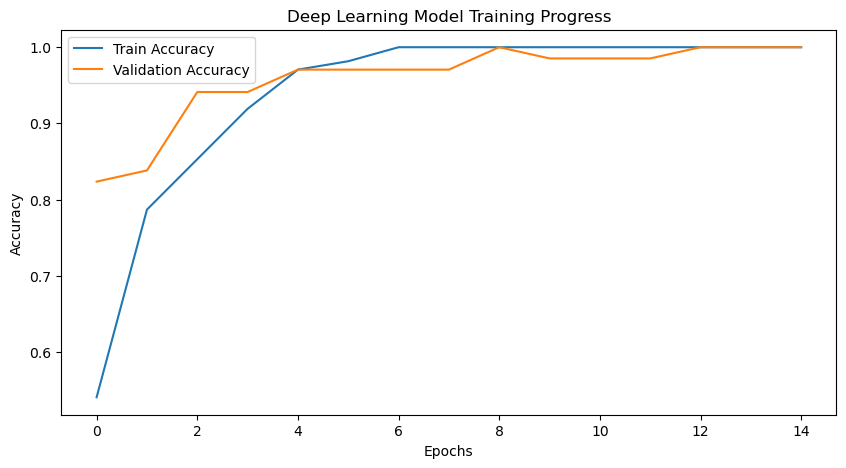

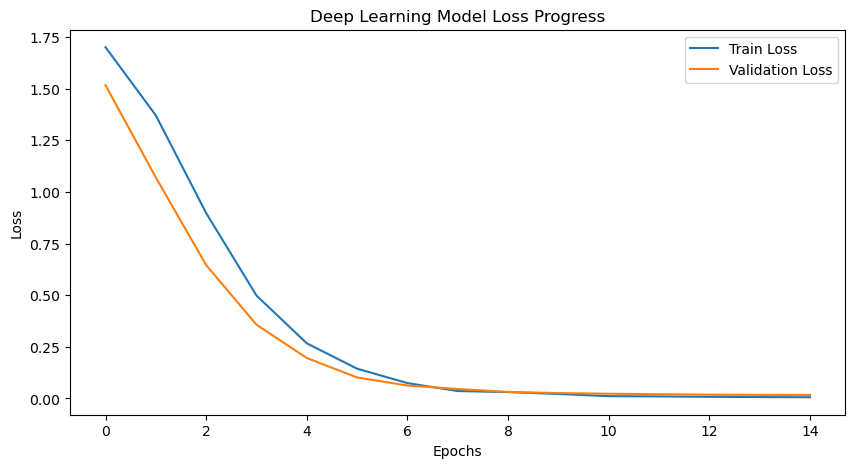

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the augmented dataset
X_dl = X_augmented.toarray()
label_encoder = LabelEncoder()
y_dl = label_encoder.fit_transform(df_augmented["os"])
y_dl = to_categorical(y_dl)  # Convert labels to one-hot encoding

# Split dataset for deep learning
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_dl, test_size=0.2, stratify=y_dl, random_state=42)

# Define deep learning model
model = Sequential([
    Input(shape=(X_train_dl.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dl, y_train_dl, epochs=15, batch_size=32, validation_data=(X_test_dl, y_test_dl), verbose=1)

# Evaluate model accuracy
dl_accuracy = model.evaluate(X_test_dl, y_test_dl, verbose=0)[1]
print(f"Deep Learning Model Accuracy: {dl_accuracy:.2f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Deep Learning Model Training Progress')
plt.legend()
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Deep Learning Model Loss Progress')
plt.legend()
plt.show()


In [40]:
# Display the first few rows of the dataset to check available features
df_balanced.head()


,ip,http_version,user_agent,os,device,browser,timestamp
4719,183.89.192.71,h2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Windows,NaN,NaN,NaN
2684,87.89.34.137,h2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Windows,NaN,NaN,NaN
7440,34.219.5.30,h2,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:1...,Windows,NaN,NaN,NaN
5777,181.139.180.139,h2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Windows,NaN,NaN,NaN
248,99.241.0.28,h2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Windows,NaN,NaN,NaN


# Anomaly Detection (Isolation Forest)

C:\Users\ehime\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


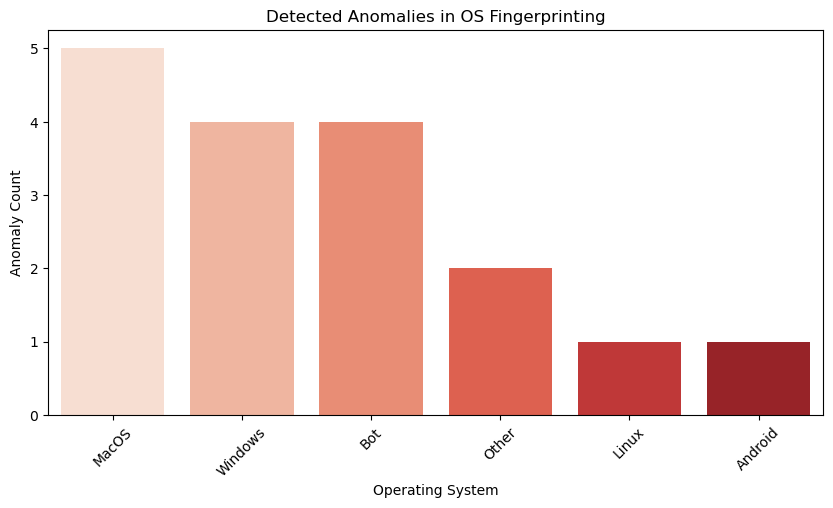

os
MacOS      5
Windows    4
Bot        4
Other      2
Linux      1
Android    1
Name: count, dtype: int64

In [42]:
from sklearn.ensemble import IsolationForest

# Train an Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Assume ~5% anomalies
anomaly_labels = iso_forest.fit_predict(X_combined)  # -1 = anomaly, 1 = normal

# Add anomaly labels to dataset for visualization
df_balanced["anomaly"] = anomaly_labels

# Count anomalies by OS type
anomaly_counts = df_balanced[df_balanced["anomaly"] == -1]["os"].value_counts()

# Plot anomaly distribution by OS
plt.figure(figsize=(10, 5))
sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette="Reds")
plt.xlabel("Operating System")
plt.ylabel("Anomaly Count")
plt.title("Detected Anomalies in OS Fingerprinting")
plt.xticks(rotation=45)
plt.show()

# Display OS anomaly counts
anomaly_counts
